### Imports

In [1]:
import pandas as pd
import torch
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from sklearn.preprocessing import MinMaxScaler
# set max num of rows and cols to display
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

### Read Pre-processed Drug-Side-Effect List 

In [2]:
df_all_se = pd.read_csv('prep_data/drug_all_se_pubchem.csv')
df_all_se.head(1)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,CID000000119,"['C0151828', 'C0030193', 'C0042109', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."


In [3]:
df_all_se.columns

Index(['STITCH ID STEREO', 'MEDRA TERM UMLS CONCEPT ID', 'se_count', 'cid',
       'mw', 'mf', 'polararea', 'complexity', 'xlogp', 'heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds', 'inchi', 'isosmiles',
       'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [4]:
drug_pub_prop_cols = [ 'mw', 'polararea', 'complexity','heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds']

In [5]:
df_all_se[drug_pub_prop_cols].isnull().sum()

mw            0
polararea     0
complexity    0
heavycnt      0
hbonddonor    0
hbondacc      0
rotbonds      0
dtype: int64

### Create Transformation Mapping for drug and side-effect

In [6]:
STITCH_TO_ID_DICT = {id: idx for idx, id in enumerate(df_all_se['STITCH ID STEREO'])}
ID_TO_STITCH_DICT = {v: k for k, v in STITCH_TO_ID_DICT.items()}

In [7]:
STITCHID_TO_PUBPPROP_DICT = {idx: _ for idx, (stid, _) in enumerate(zip(df_all_se['STITCH ID STEREO'], df_all_se[drug_pub_prop_cols].values))}


In [8]:
# Create a flattened list of unique meddra term concept id
column_list = df_all_se['MEDRA TERM UMLS CONCEPT ID'].tolist()
unique_values = list(set([item for sublist in column_list for item in eval(sublist)]))
unique_values.sort()
MEDRAID_TO_ID_DICT = {id: idx for idx, id in enumerate(unique_values)}
ID_TO_MEDRAID_DICT = {v: k for k, v in MEDRAID_TO_ID_DICT.items()}

In [9]:
# assert if df stitch id stereo is unique
assert len(df_all_se['STITCH ID STEREO'].unique()) == len(df_all_se['STITCH ID STEREO'])

### Create HeteroData

In [10]:
useMinMaxScaler = True

In [11]:
drug_node_features = torch.stack([torch.tensor(_, dtype=torch.float) for _ in df_all_se[drug_pub_prop_cols].values])
if useMinMaxScaler:
    scaler = MinMaxScaler()
    print("Before", drug_node_features.shape)
    drug_node_features = scaler.fit_transform(drug_node_features)
    print('After MinMax', drug_node_features.shape)
    drug_node_features = torch.tensor(drug_node_features, dtype=torch.float)
print("Final: UseMinMax", useMinMaxScaler, drug_node_features.shape)
# # Create a dictionary of node features
# drug_node_features = torch.tensor(np.zeros((len(df_all_se['STITCH ID STEREO']),881)))
# side_effect_node_features = torch.tensor(np.zeros((len(unique_values),881)))


# print('drug_nodes', drug_node_features.shape)
# print('side_effect_nodes', side_effect_node_features.shape)

Before torch.Size([1326, 7])
After MinMax (1326, 7)
Final: UseMinMax True torch.Size([1326, 7])


In [12]:
# create edge index for drug-side effect from multi-label column_list
edge_index = []
for idx, row in df_all_se.iterrows():
    for se in eval(row['MEDRA TERM UMLS CONCEPT ID']):
        edge_index.append([STITCH_TO_ID_DICT[row['STITCH ID STEREO']], MEDRAID_TO_ID_DICT[se]])
edge_index = torch.tensor(edge_index).T

# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', edge_index.shape)
print('edge_index', edge_index)

edge_index torch.Size([2, 129851])
edge_index tensor([[   0,    0,    0,  ..., 1325, 1325, 1325],
        [1091,  657,  889,  ...,  673,    2,  837]])


In [13]:
# # sanity check
# df_all_se.head(1)

In [14]:
# STITCH_TO_ID_DICT['CID000000119']

In [15]:
# MEDRAID_TO_ID_DICT['C0151828'], MEDRAID_TO_ID_DICT['C0030193'], MEDRAID_TO_ID_DICT['C0042109'], MEDRAID_TO_ID_DICT['C0002994']

In [16]:
# Create a heterograph with 2 types of nodes: drug and side effect
data = HeteroData()

# Add nodes
data['drug'].node_id = torch.arange(drug_node_features.shape[0])
data['side_effect'].node_id = torch.arange(len(unique_values))

# Add node features
data['drug'].x = drug_node_features

# Add edges
data['drug', 'side_effect'].edge_index = edge_index

print(data)

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] }
)


### Hetero Data Viz

In [17]:
# # Full Graph View
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# from torch_geometric.data import HeteroData


# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()

In [18]:
# # Plot random number of edges and all associated nodes
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# import random
# from torch_geometric.data import HeteroData

# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Define the number of random edges you want to visualize
# num_random_edges = 10

# # Randomly select a subset of edges
# random_edge_indices = random.sample(range(data['drug', 'side_effect'].edge_index.shape[1]), num_random_edges)

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# # sample drug_nodes to have only nodes within random_edge_indices
# drug_nodes = np.unique(data['drug', 'side_effect'].edge_index[0, random_edge_indices].numpy())
# side_effect_nodes = np.unique(data['drug', 'side_effect'].edge_index[1, random_edge_indices].numpy())


# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index[:, random_edge_indices]
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()


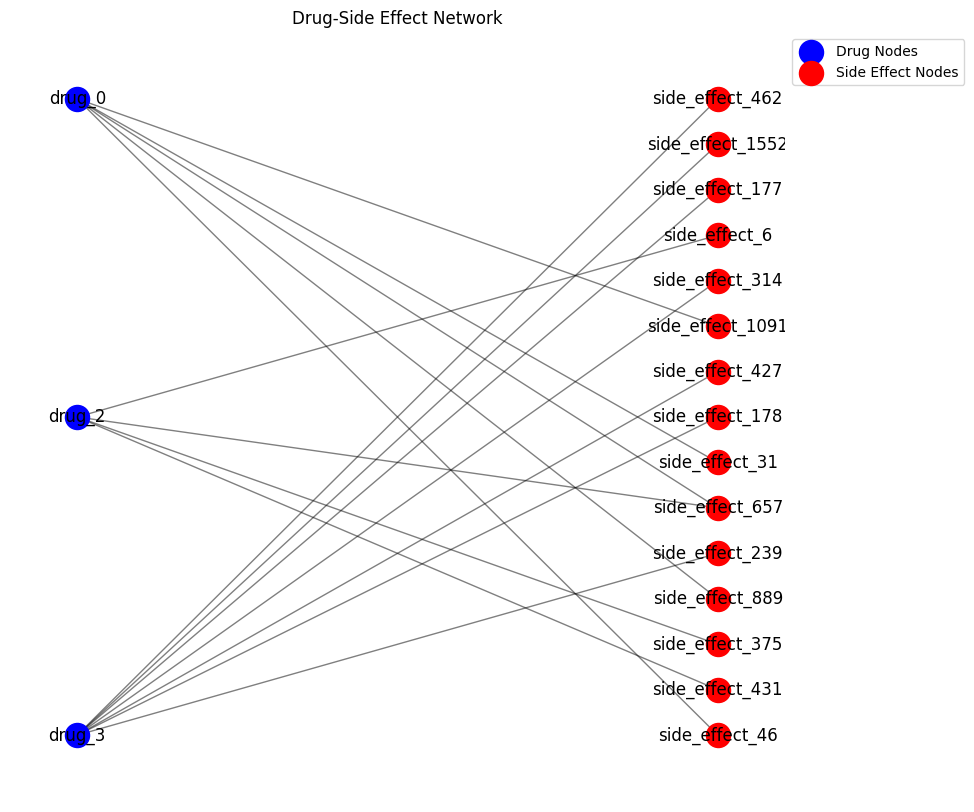

In [19]:
# plot for selected list of drug_id and all associated side effects
import networkx as nx
import matplotlib.pyplot as plt
import torch
import random
from torch_geometric.data import HeteroData, Data

# Convert heterograph to NetworkX graph
graph = nx.Graph()

# list of drug_id to visualize all its associated side effects
drug_id_list = [0, 2, 3]

# associated possible unique side effects using edge_index when drug_id is in drug_id_list
side_effect_nodes = np.unique(data['drug', 'side_effect'].edge_index[1, np.isin(data['drug', 'side_effect'].edge_index[0], drug_id_list)].numpy())

# filter out edges that are between drug_id_list and side_effect_nodes
drug_edges = data['drug', 'side_effect'].edge_index[:, np.isin(data['drug', 'side_effect'].edge_index[0], drug_id_list) & np.isin(data['drug', 'side_effect'].edge_index[1], side_effect_nodes)]

drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_id_list]
side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# Add nodes to the NetworkX graph
graph.add_nodes_from(drug_nodes_unique, node_type='drug')
graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# Add edges to the NetworkX graph
for i in range(drug_edges.shape[1]):
    source = drug_edges[0, i].item()
    target = drug_edges[1, i].item()
    source_id = f"drug_{source}"
    target_id = f"side_effect_{target}"
    graph.add_edge(source_id, target_id)

# Visualize the graph using NetworkX
# pos = nx.spring_layout(graph, seed=1)  # Compute node positions
pos = nx.bipartite_layout(graph, drug_nodes_unique, align='vertical', scale=5)  # Compute node positions
# Separate nodes by type for different visualization colors
drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# Draw nodes with different colors based on type
nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes', cmap=plt.cm.Blues)
nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes', cmap=plt.cm.Reds)

# Draw edges with different colors based on type

nx.draw_networkx_edges(graph, pos, edge_color='black', width=1.0, alpha=0.5)

# Draw edges
# nx.draw_networkx_edges(graph, pos)

# Draw node labels
node_labels = {n: str(n) for n in graph.nodes()}
nx.draw_networkx_labels(graph, pos, labels=node_labels)

# Display the graph
plt.axis('off')
# increase figure size
plt.gcf().set_size_inches(10, 10)
# position legend to the right of the graph
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Drug-Side Effect Network')
plt.show()


In [20]:
# graph.nodes()
# # link a map to most common drug_name and side_effect_name

### Hetero Link Prediction task

In [22]:
data

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] }
)

In [23]:
import torch_geometric.transforms as T
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

In [24]:
data

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] },
  (side_effect, rev_to, drug)={ edge_index=[2, 129851] }
)

### Define Edge level Train Split

In [25]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=('drug', 'to', 'side_effect'),
    rev_edge_types=('side_effect', 'rev_to', 'drug'), 
)


train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={
    edge_index=[2, 72717],
    edge_label=[31164],
    edge_label_index=[2, 31164]
  },
  (side_effect, rev_to, drug)={ edge_index=[2, 72717] }
)

Validation data:
HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={
    edge_index=[2, 103881],
    edge_label=[38955],
    edge_label_index=[2, 38955]
  },
  (side_effect, rev_to, drug)={ edge_index=[2, 103881] }
)


### Define Mini-batch Loader

In [98]:
# !pip install pyg-lib -f https://data.pyg.org/whl/torch-1.12.1+cu117.html

In [32]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader.link_neighbor_loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["drug", "to", "side_effect"].edge_label_index
edge_label = train_data["drug", "to", "side_effect"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[15, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("drug", "to", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  drug={
    node_id=[1211],
    x=[1211, 7],
    n_id=[1211]
  },
  side_effect={
    node_id=[1511],
    n_id=[1511]
  },
  (drug, to, side_effect)={
    edge_index=[2, 11062],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[11062],
    input_id=[128]
  },
  (side_effect, rev_to, drug)={
    edge_index=[2, 11453],
    e_id=[11453]
  }
)


### Creating a Hetero Link-level GNN

In [35]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.elu(self.conv1(x, edge_index)+self.lin1(x))
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x

In [36]:
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

In [65]:
# Homegenous Model for Edge Prediction
class Model(torch.nn.Module):
    def __init__(self, hidden_channels, use_node_features=False):
        super().__init__()
        # Instantiate node embeddings:
        self.drug_emb = torch.nn.Embedding(data["drug"].num_nodes, hidden_channels)
        self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, hidden_channels)
        # Instantiate GNNs:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.use_node_features = use_node_features
        if use_node_features:
            self.drug_feat_layernorm = torch.nn.LayerNorm(data["drug"].num_features)
            self.drug_lin = torch.nn.Linear(data["drug"].num_features, hidden_channels)
        # Instantiate classifier:
        self.classifier = Classifier() 

    def forward(self, data: HeteroData) -> Tensor:
        if self.use_node_features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id) + self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }
        else:
            # layer normalization of input features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id), #+ self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["drug"],
            x_dict["side_effect"],
            data["drug", "to", "side_effect"].edge_label_index,
        )

        return pred
        
model = Model(hidden_channels=256)
model

Model(
  (drug_emb): Embedding(1326, 256)
  (seff_emb): Embedding(2061, 256)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (drug__to__side_effect): SAGEConv(256, 256, aggr=mean)
      (side_effect__rev_to__drug): SAGEConv(256, 256, aggr=mean)
    )
    (lin1): ModuleDict(
      (drug): Linear(in_features=256, out_features=256, bias=True)
      (side_effect): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv2): ModuleDict(
      (drug__to__side_effect): SAGEConv(256, 256, aggr=mean)
      (side_effect__rev_to__drug): SAGEConv(256, 256, aggr=mean)
    )
    (lin2): ModuleDict(
      (drug): Linear(in_features=256, out_features=256, bias=True)
      (side_effect): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (classifier): Classifier()
)

### Train the hetero model

In [39]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 5):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["drug", "to", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 244/244 [00:07<00:00, 31.20it/s]


Epoch: 001, Loss: 0.6048


100%|██████████| 244/244 [00:07<00:00, 34.18it/s]


Epoch: 002, Loss: 0.5277


100%|██████████| 244/244 [00:06<00:00, 37.72it/s]


Epoch: 003, Loss: 0.4919


100%|██████████| 244/244 [00:06<00:00, 37.55it/s]

Epoch: 004, Loss: 0.4672


In [40]:
# Define the validation seed edges:
edge_label_index = val_data["drug", "to", "side_effect"].edge_label_index
edge_label = val_data["drug", "to", "side_effect"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[15, 10],
    edge_label_index=(("drug", "to", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  drug={
    node_id=[1201],
    x=[1201, 7],
    n_id=[1201]
  },
  side_effect={
    node_id=[1460],
    n_id=[1460]
  },
  (drug, to, side_effect)={
    edge_index=[2, 11748],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[11748],
    input_id=[384]
  },
  (side_effect, rev_to, drug)={
    edge_index=[2, 11802],
    e_id=[11802]
  }
)


/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


In [41]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        output_classes = (output_probs > 0.5).int()
        preds.append(output_classes)
        ground_truths.append(sampled_data["drug", "to", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred)
acc = (pred == ground_truth).mean()

print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

  0%|          | 0/102 [00:00<?, ?it/s]

100%|██████████| 102/102 [00:01<00:00, 52.85it/s]


Validation AUC: 0.7578
Validation AP: 0.5847
Validation F1: 0.6778
Validation Accuracy: 0.7998


### Method Train and Val

In [60]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

@torch.no_grad()
def compute_metrics(model, val_loader, debug=False):
    model.eval()
    preds = []
    ground_truths = []
    total_examples = total_loss = 0
    for sampled_data in tqdm.tqdm(val_loader):
        with torch.no_grad():
            sampled_data.to(device)
            pred = model(sampled_data)
            ground_truth = sampled_data["drug", "to", "side_effect"].edge_label
            loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
            # Applying sigmoid activation function to the predicted values
            output_probs = torch.sigmoid(pred)

            # Converting probabilities to binary class predictions
            output_classes = (output_probs > 0.5).int()
            preds.append(output_classes)
            ground_truths.append(ground_truth)

    pred = torch.cat(preds, dim=0).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

    auc = roc_auc_score(ground_truth, pred)
    ap = average_precision_score(ground_truth, pred)
    f1 = f1_score(ground_truth, pred)
    acc = (pred == ground_truth).mean()
    loss = total_loss / total_examples
    # compute precission, recall, f1, accuracy
    precission = average_precision_score(ground_truth, pred)
    recall = recall_score(ground_truth, pred)


    if debug:
        print()
        print(f"Validation AUC: {auc:.4f}")
        print(f"Validation AP: {ap:.4f}")
        print(f"Validation F1: {f1:.4f}")
        print(f"Validation Accuracy: {acc:.4f}")
        print(f"Validation precission: {precission:.4f}")
        print(f"Validation recall: {recall:.4f}")
    return loss, auc, ap, f1, acc

In [43]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = total_examples = 0
    for data in tqdm.tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        ground_truth = data["drug", "to", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(out, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * out.numel()
        total_examples += out.numel()
    return total_loss / total_examples

In [54]:
def main(model, train_loader, val_loader, test_loader, device, epochs, name):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )
    best_val_f1 = 0
    best_epoch = 0
    for epoch in range(1, epochs + 1):
        loss = train(model, train_loader, optimizer, device)
        _, train_auc, train_ap, train_f1, train_acc = compute_metrics(model, train_loader)
        # val_loss = test(model, val_loader, device)
        val_loss, val_auc, val_ap, val_f1, val_acc = compute_metrics(model, val_loader)
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}\n,\
              Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.4f}\n,\
              Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")
       
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), f"{name}.pt")
        scheduler.step(val_f1)
    
    model.load_state_dict(torch.load(f"{name}.pt"))
    return model, best_epoch

In [55]:
# Define seed edges:
test_edge_label_index = test_data["drug", "to", "side_effect"].edge_label_index
test_edge_label = test_data["drug", "to", "side_effect"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[15, 10],
    edge_label_index=(("drug", "to", "side_effect"), test_edge_label_index),
    edge_label=test_edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


In [68]:
model = Model(hidden_channels=128)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)

main(model, train_loader, val_loader, test_loader, device, epochs=20, name="bihetero_gcn_128")

Device: 'cuda'


  0%|          | 0/244 [00:00<?, ?it/s]

100%|██████████| 102/102 [00:02<00:00, 42.78it/s]


Epoch: 001, Loss: 0.7671, Val Loss: 0.5333
,              Train AUC: 0.7207, Train AP: 0.5196, Train F1: 0.6272, Train Acc: 0.7537
,              Val AUC: 0.6934, Val AP: 0.4951, Val F1: 0.5863, Val Acc: 0.7411


100%|██████████| 102/102 [00:02<00:00, 39.49it/s]


Epoch: 002, Loss: 0.4886, Val Loss: 0.4711
,              Train AUC: 0.7665, Train AP: 0.5851, Train F1: 0.6893, Train Acc: 0.7983
,              Val AUC: 0.7390, Val AP: 0.5588, Val F1: 0.6508, Val Acc: 0.7845


100%|██████████| 102/102 [00:02<00:00, 38.72it/s]


Epoch: 003, Loss: 0.4445, Val Loss: 0.4370
,              Train AUC: 0.7908, Train AP: 0.6124, Train F1: 0.7210, Train Acc: 0.8136
,              Val AUC: 0.7622, Val AP: 0.5893, Val F1: 0.6841, Val Acc: 0.8024


100%|██████████| 102/102 [00:02<00:00, 42.03it/s]


Epoch: 004, Loss: 0.4210, Val Loss: 0.4215
,              Train AUC: 0.8035, Train AP: 0.6331, Train F1: 0.7383, Train Acc: 0.8261
,              Val AUC: 0.7769, Val AP: 0.6137, Val F1: 0.7051, Val Acc: 0.8165


100%|██████████| 102/102 [00:02<00:00, 40.96it/s]


Epoch: 005, Loss: 0.4071, Val Loss: 0.4203
,              Train AUC: 0.8123, Train AP: 0.6373, Train F1: 0.7478, Train Acc: 0.8276
,              Val AUC: 0.7801, Val AP: 0.6126, Val F1: 0.7089, Val Acc: 0.8155


100%|██████████| 102/102 [00:02<00:00, 39.75it/s]


Epoch: 006, Loss: 0.3987, Val Loss: 0.4169
,              Train AUC: 0.8139, Train AP: 0.6488, Train F1: 0.7521, Train Acc: 0.8351
,              Val AUC: 0.7764, Val AP: 0.6168, Val F1: 0.7048, Val Acc: 0.8184


100%|██████████| 102/102 [00:02<00:00, 42.54it/s]


Epoch: 007, Loss: 0.3871, Val Loss: 0.4103
,              Train AUC: 0.8235, Train AP: 0.6559, Train F1: 0.7628, Train Acc: 0.8386
,              Val AUC: 0.7844, Val AP: 0.6216, Val F1: 0.7152, Val Acc: 0.8208


100%|██████████| 102/102 [00:02<00:00, 42.23it/s]


Epoch: 008, Loss: 0.3472, Val Loss: 0.3908
,              Train AUC: 0.8415, Train AP: 0.6884, Train F1: 0.7875, Train Acc: 0.8569
,              Val AUC: 0.7921, Val AP: 0.6448, Val F1: 0.7278, Val Acc: 0.8335


100%|██████████| 102/102 [00:02<00:00, 41.22it/s]


Epoch: 009, Loss: 0.3348, Val Loss: 0.3955
,              Train AUC: 0.8536, Train AP: 0.7002, Train F1: 0.8008, Train Acc: 0.8632
,              Val AUC: 0.7893, Val AP: 0.6375, Val F1: 0.7234, Val Acc: 0.8296


100%|██████████| 102/102 [00:02<00:00, 41.96it/s]


Epoch: 010, Loss: 0.3273, Val Loss: 0.3960
,              Train AUC: 0.8584, Train AP: 0.7045, Train F1: 0.8058, Train Acc: 0.8655
,              Val AUC: 0.7951, Val AP: 0.6432, Val F1: 0.7311, Val Acc: 0.8327


100%|██████████| 102/102 [00:02<00:00, 38.20it/s]


Epoch: 011, Loss: 0.3234, Val Loss: 0.4092
,              Train AUC: 0.8576, Train AP: 0.7056, Train F1: 0.8056, Train Acc: 0.8661
,              Val AUC: 0.7874, Val AP: 0.6370, Val F1: 0.7211, Val Acc: 0.8294


100%|██████████| 102/102 [00:02<00:00, 41.36it/s]


Epoch: 012, Loss: 0.3195, Val Loss: 0.4175
,              Train AUC: 0.8589, Train AP: 0.7115, Train F1: 0.8085, Train Acc: 0.8693
,              Val AUC: 0.7801, Val AP: 0.6316, Val F1: 0.7112, Val Acc: 0.8265


100%|██████████| 102/102 [00:02<00:00, 40.09it/s]


Epoch: 013, Loss: 0.3164, Val Loss: 0.4253
,              Train AUC: 0.8563, Train AP: 0.7116, Train F1: 0.8065, Train Acc: 0.8693
,              Val AUC: 0.7719, Val AP: 0.6238, Val F1: 0.6996, Val Acc: 0.8223


100%|██████████| 102/102 [00:02<00:00, 42.67it/s]


Epoch: 014, Loss: 0.2917, Val Loss: 0.4127
,              Train AUC: 0.8743, Train AP: 0.7384, Train F1: 0.8289, Train Acc: 0.8835
,              Val AUC: 0.7836, Val AP: 0.6422, Val F1: 0.7170, Val Acc: 0.8319


100%|██████████| 102/102 [00:02<00:00, 38.46it/s]


Epoch: 015, Loss: 0.2827, Val Loss: 0.4104
,              Train AUC: 0.8861, Train AP: 0.7481, Train F1: 0.8403, Train Acc: 0.8887
,              Val AUC: 0.7867, Val AP: 0.6431, Val F1: 0.7210, Val Acc: 0.8325


100%|██████████| 102/102 [00:02<00:00, 42.46it/s]


Epoch: 016, Loss: 0.2767, Val Loss: 0.4318
,              Train AUC: 0.8773, Train AP: 0.7458, Train F1: 0.8336, Train Acc: 0.8872
,              Val AUC: 0.7764, Val AP: 0.6387, Val F1: 0.7071, Val Acc: 0.8297


100%|██████████| 102/102 [00:02<00:00, 39.59it/s]


Epoch: 017, Loss: 0.2733, Val Loss: 0.4277
,              Train AUC: 0.8913, Train AP: 0.7593, Train F1: 0.8478, Train Acc: 0.8945
,              Val AUC: 0.7848, Val AP: 0.6428, Val F1: 0.7185, Val Acc: 0.8322


100%|██████████| 102/102 [00:02<00:00, 40.27it/s]


Epoch: 018, Loss: 0.2688, Val Loss: 0.4321
,              Train AUC: 0.8920, Train AP: 0.7600, Train F1: 0.8485, Train Acc: 0.8949
,              Val AUC: 0.7798, Val AP: 0.6363, Val F1: 0.7113, Val Acc: 0.8288


100%|██████████| 102/102 [00:02<00:00, 42.49it/s]


Epoch: 019, Loss: 0.2698, Val Loss: 0.4357
,              Train AUC: 0.8947, Train AP: 0.7617, Train F1: 0.8508, Train Acc: 0.8958
,              Val AUC: 0.7813, Val AP: 0.6377, Val F1: 0.7135, Val Acc: 0.8296


100%|██████████| 102/102 [00:02<00:00, 42.25it/s]

Epoch: 020, Loss: 0.2557, Val Loss: 0.4379
,              Train AUC: 0.9013, Train AP: 0.7746, Train F1: 0.8598, Train Acc: 0.9024
,              Val AUC: 0.7759, Val AP: 0.6362, Val F1: 0.7061, Val Acc: 0.8285


(Model(
   (drug_emb): Embedding(1326, 128)
   (seff_emb): Embedding(2061, 128)
   (gnn): GraphModule(
     (conv1): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin1): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
     (conv2): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin2): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
   )
   (classifier): Classifier()
 ),
 10)

In [61]:
compute_metrics(model, test_loader, debug=True)

100%|██████████| 102/102 [00:03<00:00, 33.83it/s]



Validation AUC: 0.7928
Validation AP: 0.6372
Validation F1: 0.7274
Validation Accuracy: 0.8295
Validation precission: 0.6372
Validation recall: 0.6827


(0.4012113432540864,
 0.7927801309202926,
 0.6372199813380628,
 0.7274443031223075,
 0.8294699011680143)

In [66]:
model = Model(hidden_channels=128, use_node_features=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)

main(model, train_loader, val_loader, test_loader, device, epochs=20, name="bihetero_nfeat_gcn_128")

Device: 'cuda'


  0%|          | 0/244 [00:00<?, ?it/s]

100%|██████████| 102/102 [00:02<00:00, 42.01it/s]


Epoch: 001, Loss: 0.7265, Val Loss: 0.4961
,              Train AUC: 0.7462, Train AP: 0.5480, Train F1: 0.6617, Train Acc: 0.7717
,              Val AUC: 0.7289, Val AP: 0.5335, Val F1: 0.6377, Val Acc: 0.7650


100%|██████████| 102/102 [00:02<00:00, 42.38it/s]


Epoch: 002, Loss: 0.4689, Val Loss: 0.4668
,              Train AUC: 0.8027, Train AP: 0.5923, Train F1: 0.7275, Train Acc: 0.7903
,              Val AUC: 0.7845, Val AP: 0.5768, Val F1: 0.7079, Val Acc: 0.7829


100%|██████████| 102/102 [00:02<00:00, 41.83it/s]


Epoch: 003, Loss: 0.4329, Val Loss: 0.4208
,              Train AUC: 0.8138, Train AP: 0.6291, Train F1: 0.7470, Train Acc: 0.8212
,              Val AUC: 0.7924, Val AP: 0.6123, Val F1: 0.7227, Val Acc: 0.8132


100%|██████████| 102/102 [00:02<00:00, 40.31it/s]


Epoch: 004, Loss: 0.4158, Val Loss: 0.4243
,              Train AUC: 0.7986, Train AP: 0.6277, Train F1: 0.7322, Train Acc: 0.8232
,              Val AUC: 0.7707, Val AP: 0.6046, Val F1: 0.6963, Val Acc: 0.8114


100%|██████████| 102/102 [00:02<00:00, 40.25it/s]


Epoch: 005, Loss: 0.4008, Val Loss: 0.4096
,              Train AUC: 0.8270, Train AP: 0.6510, Train F1: 0.7643, Train Acc: 0.8348
,              Val AUC: 0.7951, Val AP: 0.6252, Val F1: 0.7280, Val Acc: 0.8219


100%|██████████| 102/102 [00:02<00:00, 41.57it/s]


Epoch: 006, Loss: 0.3927, Val Loss: 0.4158
,              Train AUC: 0.8121, Train AP: 0.6504, Train F1: 0.7507, Train Acc: 0.8362
,              Val AUC: 0.7725, Val AP: 0.6139, Val F1: 0.6994, Val Acc: 0.8169


100%|██████████| 102/102 [00:02<00:00, 40.81it/s]


Epoch: 007, Loss: 0.3835, Val Loss: 0.4196
,              Train AUC: 0.8286, Train AP: 0.6523, Train F1: 0.7660, Train Acc: 0.8354
,              Val AUC: 0.7856, Val AP: 0.6123, Val F1: 0.7152, Val Acc: 0.8146


100%|██████████| 102/102 [00:02<00:00, 38.87it/s]


Epoch: 008, Loss: 0.3425, Val Loss: 0.3896
,              Train AUC: 0.8562, Train AP: 0.6949, Train F1: 0.8009, Train Acc: 0.8600
,              Val AUC: 0.8069, Val AP: 0.6479, Val F1: 0.7449, Val Acc: 0.8350


100%|██████████| 102/102 [00:02<00:00, 37.98it/s]


Epoch: 009, Loss: 0.3306, Val Loss: 0.4025
,              Train AUC: 0.8459, Train AP: 0.6991, Train F1: 0.7943, Train Acc: 0.8627
,              Val AUC: 0.7827, Val AP: 0.6382, Val F1: 0.7153, Val Acc: 0.8299


100%|██████████| 102/102 [00:02<00:00, 39.89it/s]


Epoch: 010, Loss: 0.3242, Val Loss: 0.4047
,              Train AUC: 0.8646, Train AP: 0.7108, Train F1: 0.8124, Train Acc: 0.8689
,              Val AUC: 0.7933, Val AP: 0.6369, Val F1: 0.7279, Val Acc: 0.8293


100%|██████████| 102/102 [00:02<00:00, 38.22it/s]


Epoch: 011, Loss: 0.3214, Val Loss: 0.4083
,              Train AUC: 0.8668, Train AP: 0.7091, Train F1: 0.8133, Train Acc: 0.8678
,              Val AUC: 0.7924, Val AP: 0.6329, Val F1: 0.7263, Val Acc: 0.8270


100%|██████████| 102/102 [00:02<00:00, 39.90it/s]


Epoch: 012, Loss: 0.3179, Val Loss: 0.4174
,              Train AUC: 0.8668, Train AP: 0.7167, Train F1: 0.8160, Train Acc: 0.8721
,              Val AUC: 0.7815, Val AP: 0.6256, Val F1: 0.7122, Val Acc: 0.8232


100%|██████████| 102/102 [00:02<00:00, 39.32it/s]


Epoch: 013, Loss: 0.3117, Val Loss: 0.4212
,              Train AUC: 0.8661, Train AP: 0.7166, Train F1: 0.8155, Train Acc: 0.8720
,              Val AUC: 0.7869, Val AP: 0.6344, Val F1: 0.7200, Val Acc: 0.8280


100%|██████████| 102/102 [00:02<00:00, 39.00it/s]


Epoch: 014, Loss: 0.2874, Val Loss: 0.4134
,              Train AUC: 0.8825, Train AP: 0.7453, Train F1: 0.8369, Train Acc: 0.8872
,              Val AUC: 0.7871, Val AP: 0.6436, Val F1: 0.7216, Val Acc: 0.8328


100%|██████████| 102/102 [00:02<00:00, 35.53it/s]


Epoch: 015, Loss: 0.2762, Val Loss: 0.4217
,              Train AUC: 0.8881, Train AP: 0.7494, Train F1: 0.8421, Train Acc: 0.8895
,              Val AUC: 0.7865, Val AP: 0.6411, Val F1: 0.7205, Val Acc: 0.8315


100%|██████████| 102/102 [00:02<00:00, 35.83it/s]


Epoch: 016, Loss: 0.2719, Val Loss: 0.4266
,              Train AUC: 0.8895, Train AP: 0.7534, Train F1: 0.8444, Train Acc: 0.8915
,              Val AUC: 0.7817, Val AP: 0.6346, Val F1: 0.7136, Val Acc: 0.8280


100%|██████████| 102/102 [00:02<00:00, 37.27it/s]


Epoch: 017, Loss: 0.2683, Val Loss: 0.4333
,              Train AUC: 0.8943, Train AP: 0.7601, Train F1: 0.8500, Train Acc: 0.8951
,              Val AUC: 0.7844, Val AP: 0.6402, Val F1: 0.7177, Val Acc: 0.8309


100%|██████████| 102/102 [00:02<00:00, 38.05it/s]


Epoch: 018, Loss: 0.2655, Val Loss: 0.4545
,              Train AUC: 0.8846, Train AP: 0.7552, Train F1: 0.8419, Train Acc: 0.8921
,              Val AUC: 0.7674, Val AP: 0.6268, Val F1: 0.6936, Val Acc: 0.8235


100%|██████████| 102/102 [00:02<00:00, 37.67it/s]


Epoch: 019, Loss: 0.2657, Val Loss: 0.4436
,              Train AUC: 0.8975, Train AP: 0.7673, Train F1: 0.8547, Train Acc: 0.8987
,              Val AUC: 0.7763, Val AP: 0.6329, Val F1: 0.7063, Val Acc: 0.8270


100%|██████████| 102/102 [00:02<00:00, 38.99it/s]

Epoch: 020, Loss: 0.2495, Val Loss: 0.4460
,              Train AUC: 0.9045, Train AP: 0.7796, Train F1: 0.8636, Train Acc: 0.9049
,              Val AUC: 0.7747, Val AP: 0.6341, Val F1: 0.7043, Val Acc: 0.8274


(Model(
   (drug_emb): Embedding(1326, 128)
   (seff_emb): Embedding(2061, 128)
   (gnn): GraphModule(
     (conv1): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin1): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
     (conv2): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin2): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
   )
   (drug_feat_layernorm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
   (drug_lin): Linear(in_features=7, out_features=128, bias=True)
   (classifier): Classifier()
 ),
 8)

In [67]:
compute_metrics(model, test_loader, debug=True)

100%|██████████| 102/102 [00:02<00:00, 37.73it/s]


Validation AUC: 0.8034
Validation AP: 0.6425
Validation F1: 0.7401
Validation Accuracy: 0.8321
Validation precission: 0.6425
Validation recall: 0.7173


(0.39617568284537086,
 0.8033692722371969,
 0.6425201916692382,
 0.7400874056416369,
 0.8320626363753049)